In [2]:
!pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/00/09/abb305dce85911b8fba382926cfc57f2f257729e25937fdcc63f3a1a67f9/wordcloud-1.9.4-cp311-cp311-win_amd64.whl.metadata
  Using cached wordcloud-1.9.4-cp311-cp311-win_amd64.whl.metadata (3.5 kB)
Using cached wordcloud-1.9.4-cp311-cp311-win_amd64.whl (299 kB)


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud
from collections import Counter

# Download necessary NLTK data
nltk.download(['punkt', 'stopwords', 'wordnet', 'vader_lexicon'])

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

[nltk_data] Downloading package punkt to C:\Users\This
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\This
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\This
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\This
[nltk_data]     PC\AppData\Roaming\nltk_data...


# DATA LOADING AND HEADING

In [6]:
# Load the dataset
try:
    df = pd.read_csv('flipkart_mobile_reviews.csv')
    print("Dataset loaded successfully!")
    print(f"Shape of dataset: {df.shape}")
    print("\nFirst few rows:")
    display(df.head())
except FileNotFoundError:
    print("Please ensure the file 'flipkart_mobile_reviews.csv' is in your working directory.")
    # Create sample data for demonstration if file not found
    data = {
        'Review': [
            "This phone is amazing! The camera quality is superb and battery lasts long.",
            "Not satisfied with the product. It heats up too much during normal use.",
            "Decent phone for the price. Could be better but okay for daily use.",
            "The display is fantastic but the speaker quality is poor.",
            "Worst experience ever! Phone stopped working after 2 days."
        ],
        'Rating': [5, 2, 3, 4, 1]
    }
    df = pd.DataFrame(data)
    print("\nUsing sample data for demonstration:")
    display(df)

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Drop rows with missing reviews if any
df = df.dropna(subset=['Review'])
df = df.reset_index(drop=True)

# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    words = nltk.word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join words back to sentence
    return ' '.join(words)

# Apply preprocessing
df['Cleaned_Review'] = df['Review'].apply(preprocess_text)

print("\nAfter preprocessing - First few rows:")
display(df.head())

Please ensure the file 'flipkart_mobile_reviews.csv' is in your working directory.

Using sample data for demonstration:


,Review,Rating
0,This phone is amazing! The camera quality is s...,5
1,Not satisfied with the product. It heats up to...,2
2,Decent phone for the price. Could be better bu...,3
3,The display is fantastic but the speaker quali...,4
4,Worst experience ever! Phone stopped working a...,1



Missing values in each column:
Review    0
Rating    0
dtype: int64

After preprocessing - First few rows:


,Review,Rating,Cleaned_Review
0,This phone is amazing! The camera quality is s...,5,phone amazing camera quality superb battery la...
1,Not satisfied with the product. It heats up to...,2,satisfied product heat much normal use
2,Decent phone for the price. Could be better bu...,3,decent phone price could better okay daily use
3,The display is fantastic but the speaker quali...,4,display fantastic speaker quality poor
4,Worst experience ever! Phone stopped working a...,1,worst experience ever phone stopped working day


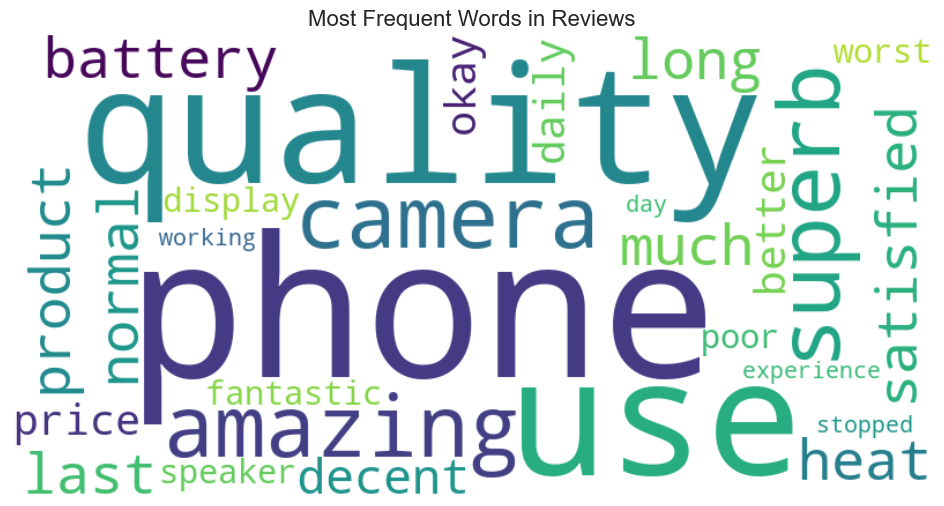

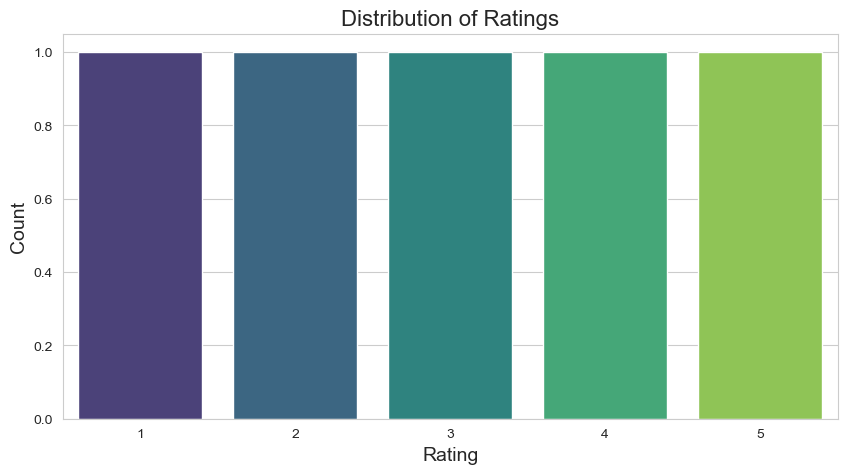

In [7]:
# Word cloud for most frequent words
def plot_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, 
                          background_color='white', 
                          max_words=100).generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Frequent Words in Reviews', fontsize=16)
    plt.show()

# Combine all reviews for word cloud
all_reviews = ' '.join(df['Cleaned_Review'])
plot_wordcloud(all_reviews)

# Plot rating distribution if 'Rating' column exists
if 'Rating' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(x='Rating', data=df, palette='viridis')
    plt.title('Distribution of Ratings', fontsize=16)
    plt.xlabel('Rating', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.show()

# SENTIMENT ANALYSIS

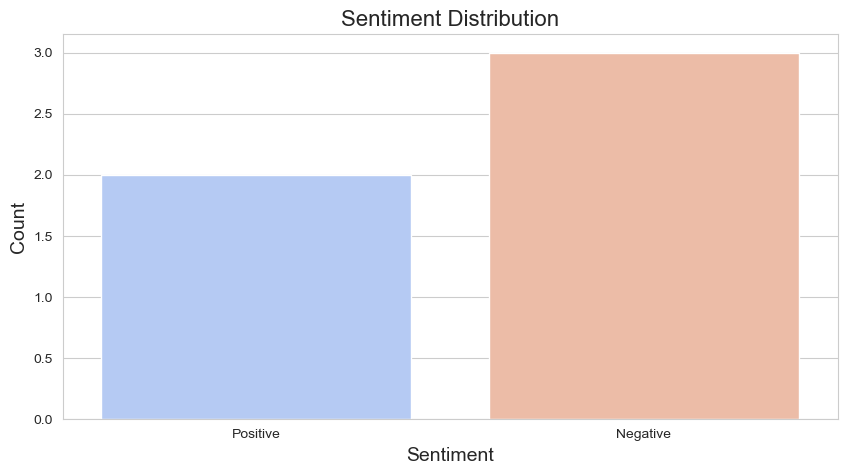

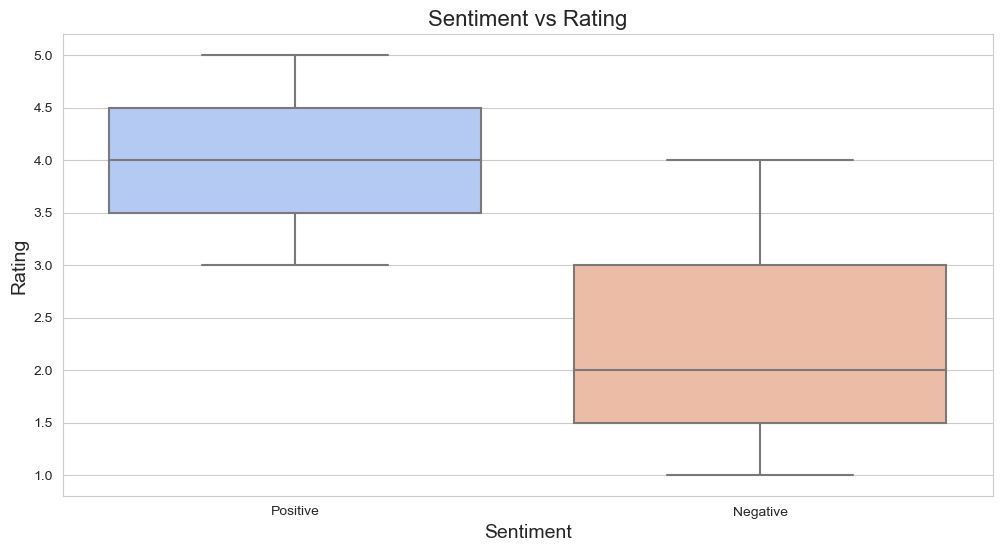


Sample Reviews by Sentiment:

Positive Reviews:
1. This phone is amazing! The camera quality is superb and battery lasts long.
2. Decent phone for the price. Could be better but okay for daily use.

Neutral Reviews:

Negative Reviews:
1. Not satisfied with the product. It heats up too much during normal use.
2. The display is fantastic but the speaker quality is poor.


In [18]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    # Classify based on compound score
    if scores['compound'] >= 0.05:
        return 'Positive'
    elif scores['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment analysis
df['Sentiment'] = df['Review'].apply(get_sentiment)

# Display sentiment distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='Sentiment', data=df, palette='coolwarm')
plt.title('Sentiment Distribution', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

# Compare sentiment with ratings if available
if 'Rating' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Sentiment', y='Rating', data=df, palette='coolwarm')
    plt.title('Sentiment vs Rating', fontsize=16)
    plt.xlabel('Sentiment', fontsize=14)
    plt.ylabel('Rating', fontsize=14)
    plt.show()

# Display some sample reviews for each sentiment
print("\nSample Reviews by Sentiment:")
for sentiment in ['Positive', 'Neutral', 'Negative']:
    print(f"\n{sentiment} Reviews:")
    sample_reviews = df[df['Sentiment'] == sentiment]['Review'].head(2).tolist()
    for i, review in enumerate(sample_reviews, 1):
        print(f"{i}. {review}")

# Topic Modelling using LDA

LDA Topics:
Topic 1:
phone use quality
Topic 2:
quality phone use
Topic 3:
phone use quality
Topic 4:
use phone quality
Topic 5:
phone use quality

NMF Topics:
Topic 1:
use phone quality
Topic 2:
phone quality use
Topic 3:
quality use phone
Topic 4:
quality use phone
Topic 5:
quality use phone


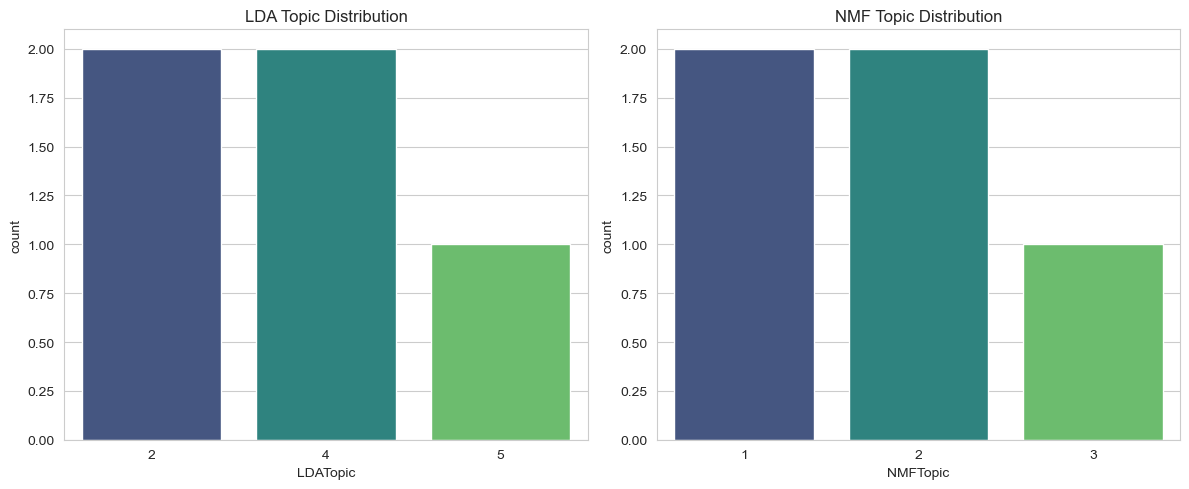

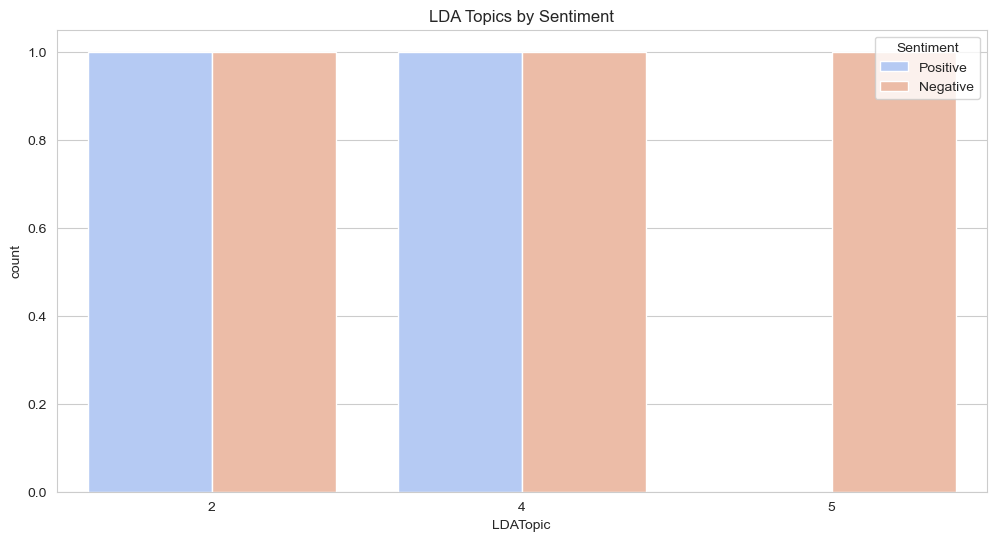

In [9]:
# Vectorize the text data
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000)
tfidf = tfidf_vectorizer.fit_transform(df['Cleaned_Review'])

# LDA Model
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda_model.fit_transform(tfidf)

# Function to display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display LDA topics
print("LDA Topics:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
display_topics(lda_model, tfidf_feature_names, 10)

# NMF Model
nmf_model = NMF(n_components=5, random_state=42)
nmf_topics = nmf_model.fit_transform(tfidf)

# Display NMF topics
print("\nNMF Topics:")
display_topics(nmf_model, tfidf_feature_names, 10)

# Assign dominant topic to each review
def assign_topic(model, text_vector):
    topic_values = model.transform(text_vector)
    return topic_values.argmax(axis=1) + 1  # +1 to make topics start from 1

df['LDATopic'] = assign_topic(lda_model, tfidf)
df['NMFTopic'] = assign_topic(nmf_model, tfidf)

# Display topic distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='LDATopic', data=df, palette='viridis')
plt.title('LDA Topic Distribution')
plt.subplot(1, 2, 2)
sns.countplot(x='NMFTopic', data=df, palette='viridis')
plt.title('NMF Topic Distribution')
plt.tight_layout()
plt.show()

# Analyze topics by sentiment
plt.figure(figsize=(12, 6))
sns.countplot(x='LDATopic', hue='Sentiment', data=df, palette='coolwarm')
plt.title('LDA Topics by Sentiment')
plt.show()

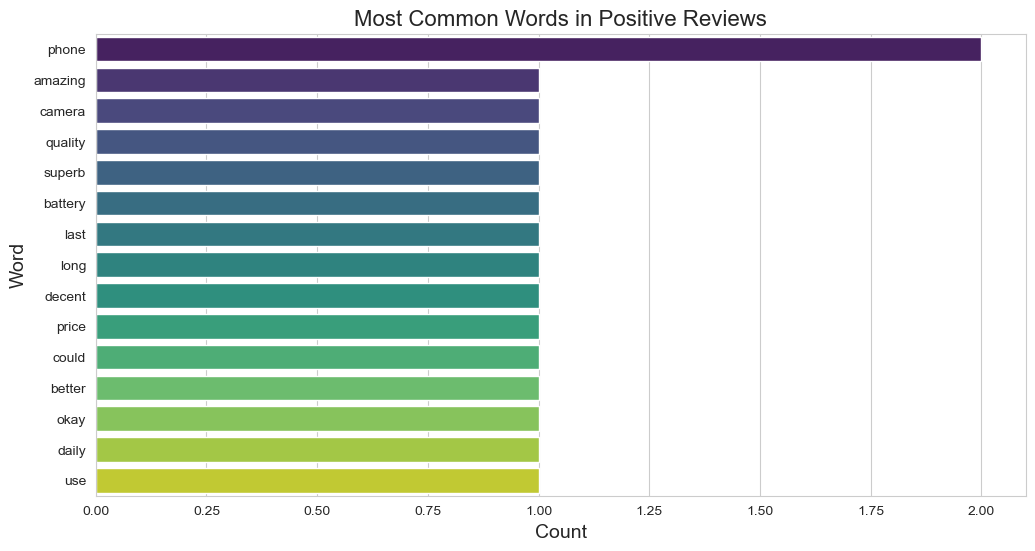

No Neutral reviews found. Skipping visualization.


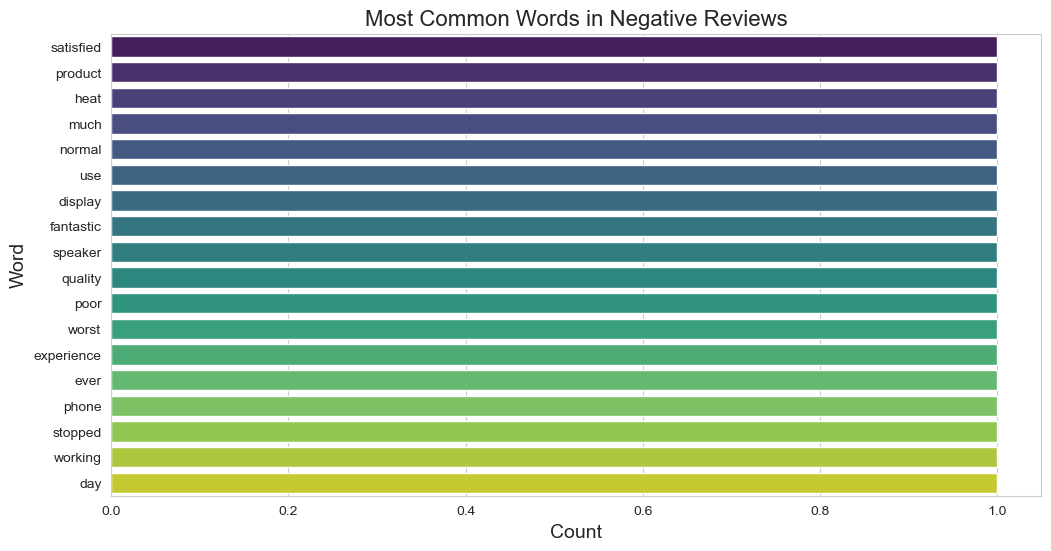

In [11]:

def plot_common_words_by_sentiment(sentiment, n_words=20):
    # Check if there are any reviews for this sentiment
    sentiment_reviews = df[df['Sentiment'] == sentiment]['Cleaned_Review']
    if len(sentiment_reviews) == 0:
        print(f"No {sentiment} reviews found. Skipping visualization.")
        return
    
    words = ' '.join(sentiment_reviews).split()
    word_counts = Counter(words)
    common_words = word_counts.most_common(n_words)
    
    if not common_words:  # Check if common_words is empty
        print(f"No words found for {sentiment} sentiment.")
        return
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=[count for word, count in common_words], 
                y=[word for word, count in common_words], 
                palette='viridis')
    plt.title(f'Most Common Words in {sentiment} Reviews', fontsize=16)
    plt.xlabel('Count', fontsize=14)
    plt.ylabel('Word', fontsize=14)
    plt.show()

for sentiment in ['Positive', 'Neutral', 'Negative']:
    plot_common_words_by_sentiment(sentiment)

In [13]:
# Generate a final report
print("\nFINAL ANALYSIS REPORT")
print("="*50)

# Sentiment summary - SAFE VERSION
sentiment_counts = df['Sentiment'].value_counts(normalize=True) * 100

print("\nSentiment Distribution:")
# Check each sentiment category exists before printing
for sentiment in ['Positive', 'Neutral', 'Negative']:
    if sentiment in sentiment_counts:
        print(f"{sentiment}: {sentiment_counts[sentiment]:.1f}%")
    else:
        print(f"{sentiment}: 0.0% (no reviews with this sentiment)")


FINAL ANALYSIS REPORT

Sentiment Distribution:
Positive: 40.0%
Neutral: 0.0% (no reviews with this sentiment)
Negative: 60.0%
